C:\Users\arika\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\arika\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\arika\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\arika\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

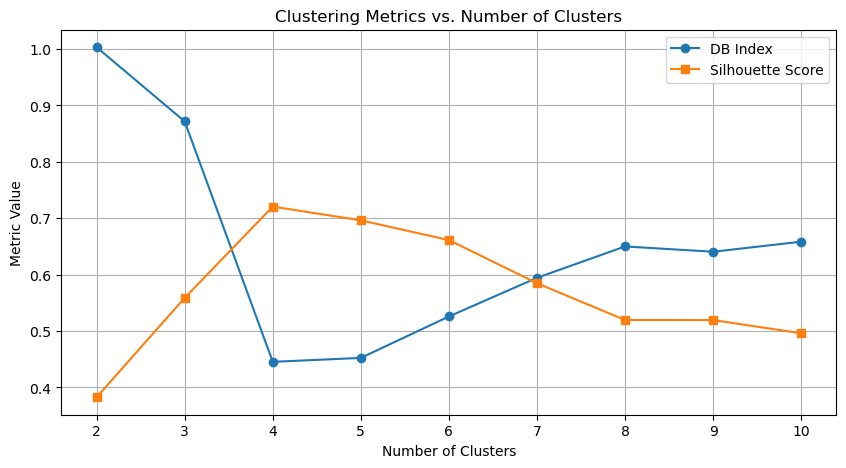

C:\Users\arika\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


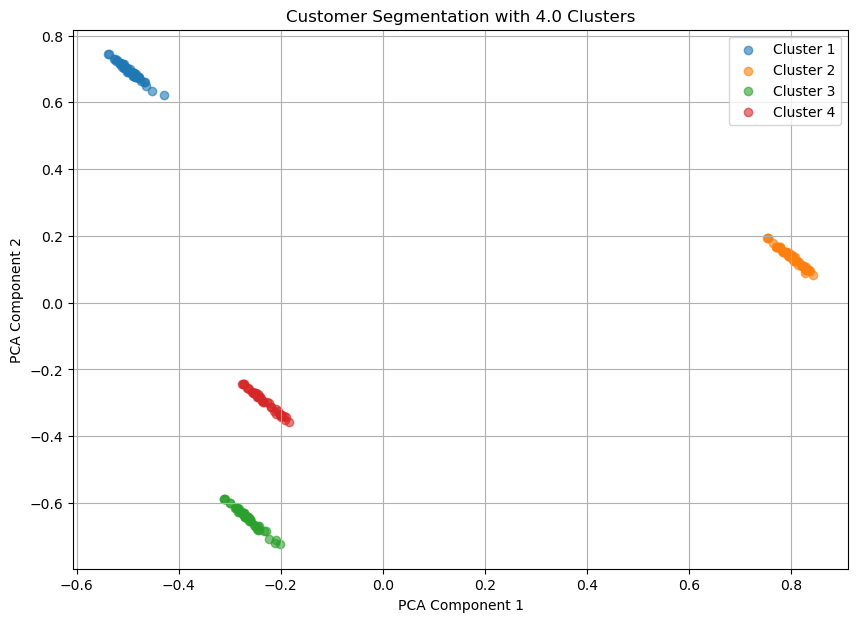

Optimal Number of Clusters: 4
DB Index for Optimal Clusters: 0.44543161490596045


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Step 1: Load Data
# Load customer and transaction data
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

# Step 2: Feature Engineering
# Aggregate transaction data for each customer
customer_profiles = transactions.groupby("CustomerID").agg(
    TotalRevenue=("TotalValue", "sum"),
    TotalTransactions=("TransactionID", "count"),
    PurchaseFrequency=("TransactionDate", lambda x: len(pd.to_datetime(x).dt.date.unique()))
).reset_index()

# Merge customer demographics with transaction features
merged_data = pd.merge(customers, customer_profiles, on="CustomerID", how="inner")

# One-hot encode categorical features (Region, PreferredCategory)
# One-hot encode categorical features (only 'Region' as 'PreferredCategory' is missing)
categorical_features = ["Region"]
encoder = OneHotEncoder(sparse_output=False)
encoded_categorical = encoder.fit_transform(merged_data[categorical_features])

# Normalize numerical features (TotalRevenue, TotalTransactions, PurchaseFrequency)
numerical_features = ["TotalRevenue", "TotalTransactions", "PurchaseFrequency"]
scaler = MinMaxScaler()
normalized_numerical = scaler.fit_transform(merged_data[numerical_features])

# Combine all features into a single matrix
feature_matrix = np.hstack([encoded_categorical, normalized_numerical])


# Step 3: Apply Clustering
# Experiment with different numbers of clusters
cluster_metrics = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(feature_matrix)

    # Calculate DB Index and Silhouette Score
    db_index = davies_bouldin_score(feature_matrix, cluster_labels)
    silhouette_avg = silhouette_score(feature_matrix, cluster_labels)

    cluster_metrics.append({
        "n_clusters": n_clusters,
        "DB_Index": db_index,
        "Silhouette_Score": silhouette_avg
    })

# Convert metrics to DataFrame for analysis
metrics_df = pd.DataFrame(cluster_metrics)

# Step 4: Visualize Clustering Metrics
plt.figure(figsize=(10, 5))
plt.plot(metrics_df["n_clusters"], metrics_df["DB_Index"], marker="o", label="DB Index")
plt.plot(metrics_df["n_clusters"], metrics_df["Silhouette_Score"], marker="s", label="Silhouette Score")
plt.title("Clustering Metrics vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Metric Value")
plt.legend()
plt.grid()
plt.show()

# Step 5: Optimal Clustering and Visualization
optimal_clusters = metrics_df.sort_values("DB_Index").iloc[0]["n_clusters"]
kmeans = KMeans(n_clusters=int(optimal_clusters), random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(feature_matrix)

# Reduce dimensions for visualization using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(feature_matrix)

# Plot clusters
plt.figure(figsize=(10, 7))
for cluster in np.unique(cluster_labels):
    plt.scatter(
        reduced_features[cluster_labels == cluster, 0],
        reduced_features[cluster_labels == cluster, 1],
        label=f"Cluster {cluster + 1}", alpha=0.6
    )
plt.title(f"Customer Segmentation with {optimal_clusters} Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid()
plt.show()

# Save results to CSV
merged_data["Cluster"] = cluster_labels
merged_data.to_csv("Customer_Segments.csv", index=False)

# Print DB Index and Optimal Clusters
print(f"Optimal Number of Clusters: {int(optimal_clusters)}")
print(f"DB Index for Optimal Clusters: {metrics_df.sort_values('DB_Index').iloc[0]['DB_Index']}")

# Documentation:
# This script performs customer segmentation using K-Means clustering. It evaluates clustering quality using the Davies-Bouldin Index and Silhouette Score, selects the optimal number of clusters, and visualizes the results. Clustering results are saved in 'Customer_Segments.csv'.
